In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.svm import SVR
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

In [2]:
train = pd.read_csv('Data/BigMart Sales/train.csv')
test = pd.read_csv('Data/BigMart Sales/test.csv')

In [3]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
train.shape

(8523, 12)

In [5]:
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [6]:
test.shape

(5681, 11)

# EDA

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [8]:
train.iloc[:,:-1].nunique()

Item_Identifier              1559
Item_Weight                   415
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     3
Outlet_Location_Type            3
Outlet_Type                     4
dtype: int64

In [9]:
for i in train.select_dtypes(object).columns[1:-1]:
    print('The unique values for feature '+  "\033[1m" + i + "\033[0m" + ' are: ',end='')
    print(*train[i].unique(),sep=', ')  
    print()

The unique values for feature Item_Fat_Content are: Low Fat, Regular, low fat, LF, reg

The unique values for feature Item_Type are: Dairy, Soft Drinks, Meat, Fruits and Vegetables, Household, Baking Goods, Snack Foods, Frozen Foods, Breakfast, Health and Hygiene, Hard Drinks, Canned, Breads, Starchy Foods, Others, Seafood

The unique values for feature Outlet_Identifier are: OUT049, OUT018, OUT010, OUT013, OUT027, OUT045, OUT017, OUT046, OUT035, OUT019

The unique values for feature Outlet_Size are: Medium, nan, High, Small

The unique values for feature Outlet_Location_Type are: Tier 1, Tier 3, Tier 2



**The feature Item_Fat_Content has repeated values**

In [10]:
train['Item_Fat_Content'] = train['Item_Fat_Content'].apply(lambda x: 'Low Fat' if 'f' in x.lower() else 'Regular') 

In [11]:
train.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [12]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Item_Weight,7060.0,12.857645,4.643456,4.555,8.773750,12.600000,16.850000,21.350000
Item_Visibility,8523.0,0.066132,0.051598,0.000,0.026989,0.053931,0.094585,0.328391
Item_MRP,8523.0,140.992782,62.275067,31.290,93.826500,143.012800,185.643700,266.888400
Outlet_Establishment_Year,8523.0,1997.831867,8.371760,1985.000,1987.000000,1999.000000,2004.000000,2009.000000
Item_Outlet_Sales,8523.0,2181.288914,1706.499616,33.290,834.247400,1794.331000,3101.296400,13086.964800


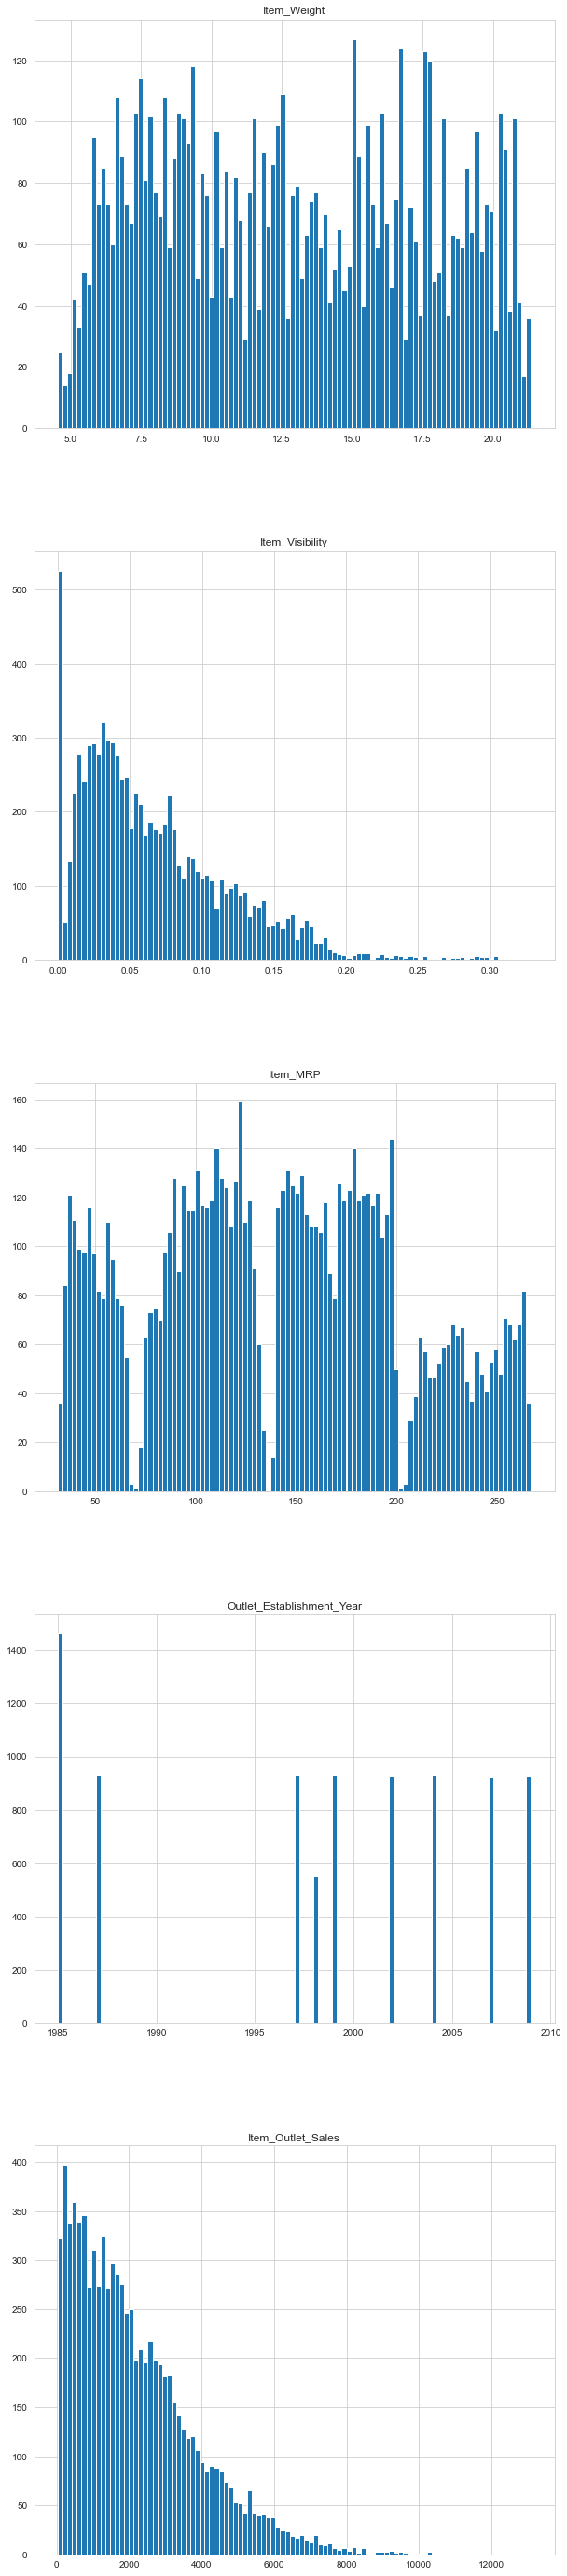

In [13]:
train.hist(figsize=(10,50),layout=(5,1), bins=100);

		The distrubution of the feature Item_Weight



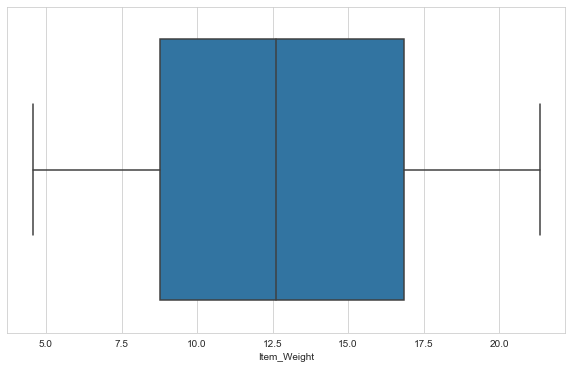

----------------------------------------------------------------------------------------------------

		The distrubution of the feature Item_Visibility



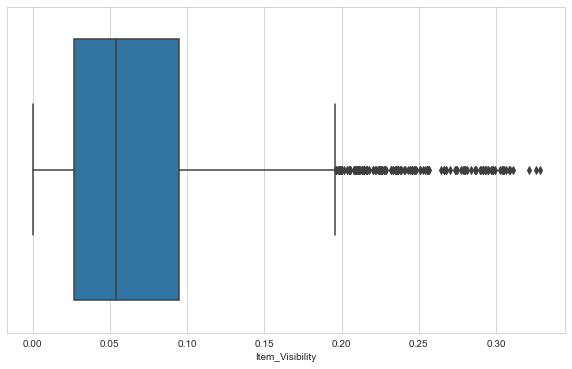

----------------------------------------------------------------------------------------------------

		The distrubution of the feature Item_MRP



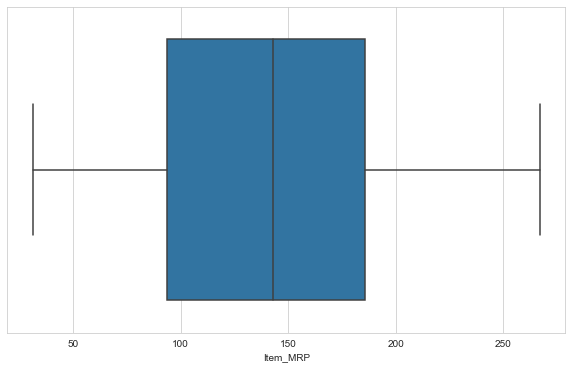

----------------------------------------------------------------------------------------------------

		The distrubution of the feature Outlet_Establishment_Year



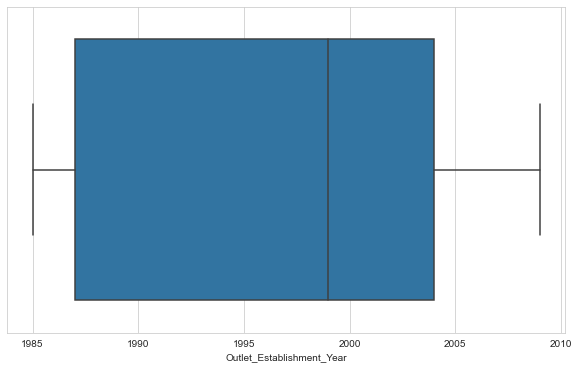

----------------------------------------------------------------------------------------------------

		The distrubution of the feature Item_Outlet_Sales



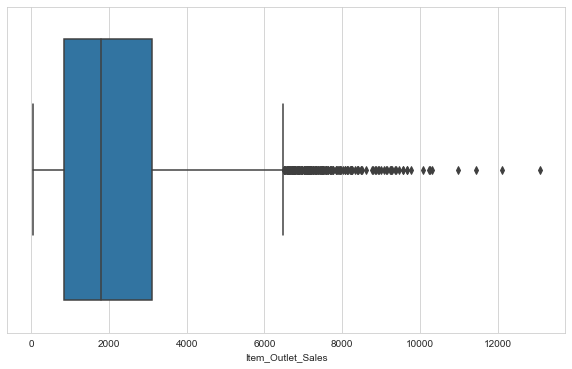

----------------------------------------------------------------------------------------------------



In [14]:
for i in train.select_dtypes(np.number).columns:
    print('\t\tThe distrubution of the feature '+ "\033[1m" + i + "\033[0m")
    print()
    plt.figure(figsize=(10,6))
    sns.boxplot(x=train[i])
    plt.show()
    print('----------'*10)
    print()

		The distrubution of the feature Item_Fat_Content

         Item_Fat_Content
Low Fat              5517
Regular              3006


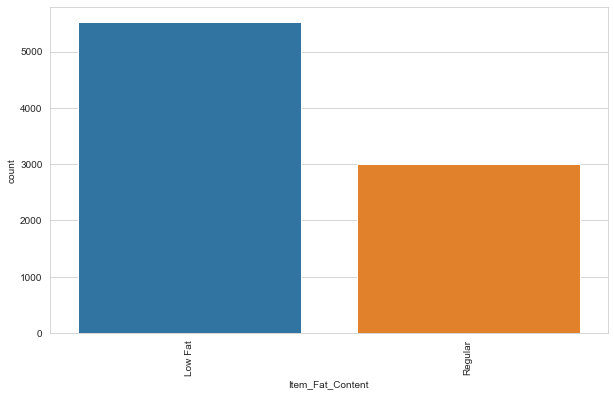

----------------------------------------------------------------------------------------------------

		The distrubution of the feature Item_Type

                       Item_Type
Fruits and Vegetables       1232
Snack Foods                 1200
Household                    910
Frozen Foods                 856
Dairy                        682
Canned                       649
Baking Goods                 648
Health and Hygiene           520
Soft Drinks                  445
Meat                         425
Breads                       251
Hard Drinks                  214
Others                       169
Starchy Foods                148
Breakfast                    110
Seafood                       64


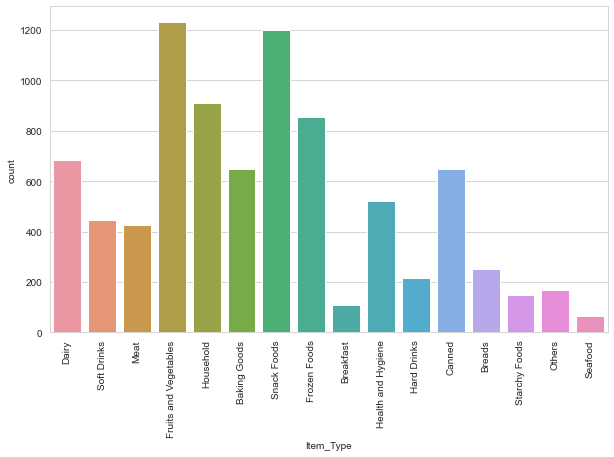

----------------------------------------------------------------------------------------------------

		The distrubution of the feature Outlet_Identifier

        Outlet_Identifier
OUT027                935
OUT013                932
OUT046                930
OUT035                930
OUT049                930
OUT045                929
OUT018                928
OUT017                926
OUT010                555
OUT019                528


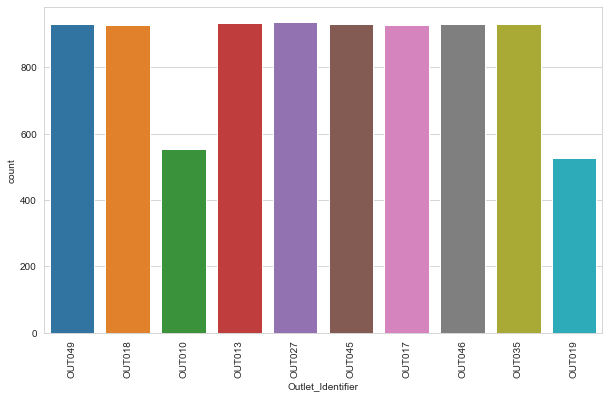

----------------------------------------------------------------------------------------------------

		The distrubution of the feature Outlet_Size

        Outlet_Size
Medium         2793
Small          2388
High            932


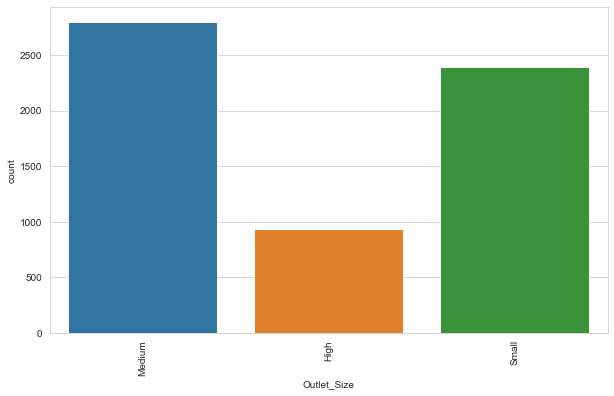

----------------------------------------------------------------------------------------------------

		The distrubution of the feature Outlet_Location_Type

        Outlet_Location_Type
Tier 3                  3350
Tier 2                  2785
Tier 1                  2388


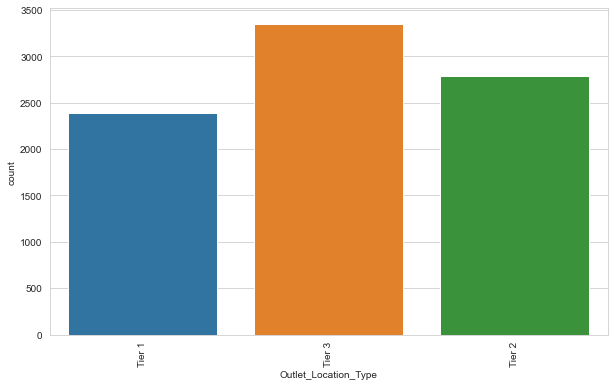

----------------------------------------------------------------------------------------------------



In [15]:
for i in train.select_dtypes(object).columns[1:-1]:
    print('\t\tThe distrubution of the feature '+ "\033[1m" + i + "\033[0m")
    print()
    print(pd.DataFrame(train[i].value_counts()))
    plt.figure(figsize=(10,6))
    sns.countplot(x=train[i])
    plt.xticks(rotation=90)
    plt.show()
    print('----------'*10)
    print()

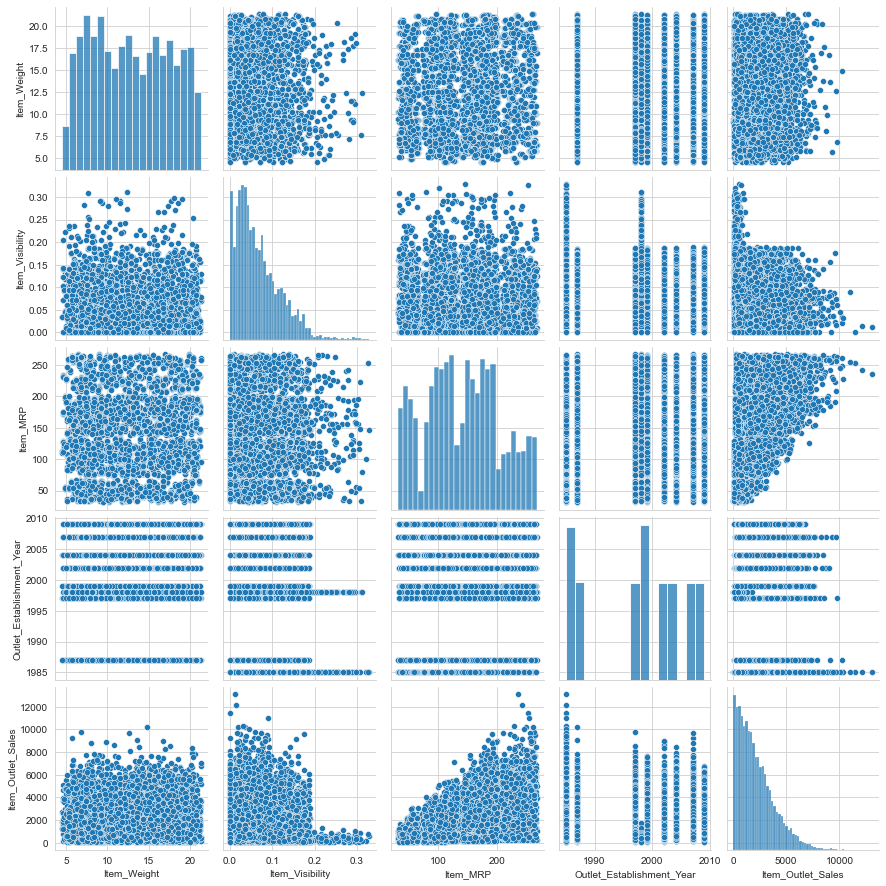

In [16]:
sns.pairplot(data=train)
plt.show()

		The impact of the feature Item_Fat_Content On Item_Outlet_Sales


<Figure size 720x432 with 0 Axes>

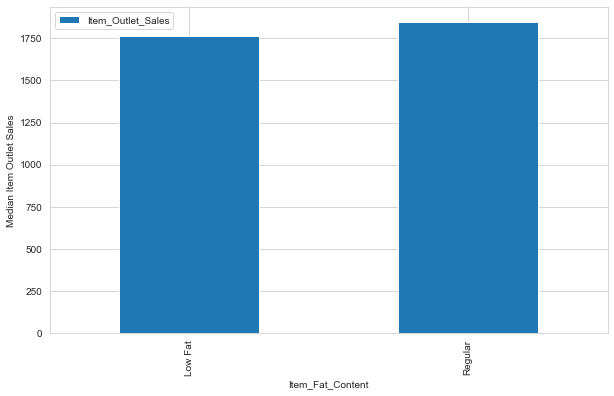

----------------------------------------------------------------------------------------------------

		The impact of the feature Item_Type On Item_Outlet_Sales


<Figure size 720x432 with 0 Axes>

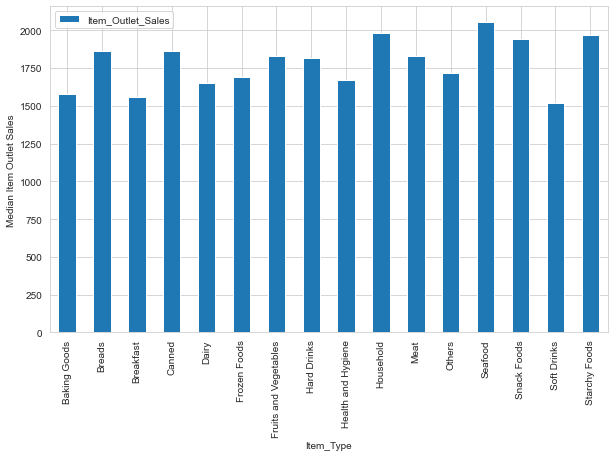

----------------------------------------------------------------------------------------------------

		The impact of the feature Outlet_Identifier On Item_Outlet_Sales


<Figure size 720x432 with 0 Axes>

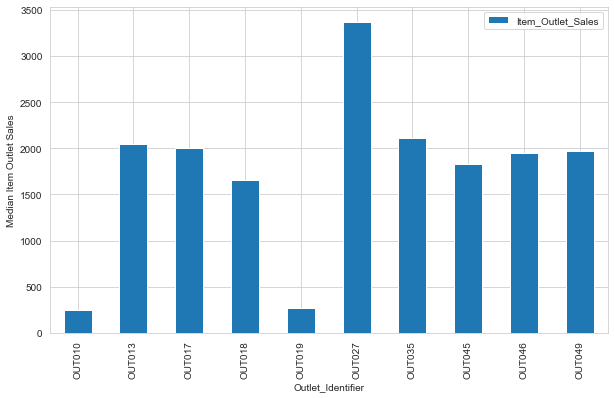

----------------------------------------------------------------------------------------------------

		The impact of the feature Outlet_Size On Item_Outlet_Sales


<Figure size 720x432 with 0 Axes>

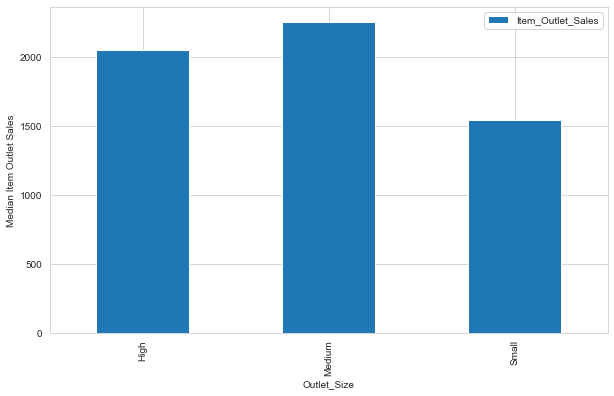

----------------------------------------------------------------------------------------------------

		The impact of the feature Outlet_Location_Type On Item_Outlet_Sales


<Figure size 720x432 with 0 Axes>

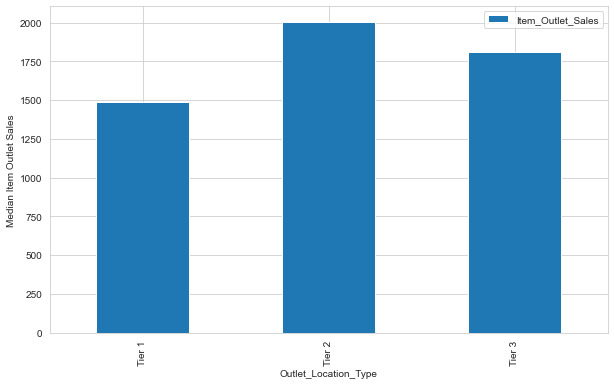

----------------------------------------------------------------------------------------------------



In [17]:
for i in train.select_dtypes(object).columns[1:-1]:
    print('\t\tThe impact of the feature '+ "\033[1m" + i + ' On Item_Outlet_Sales'+ "\033[0m")
    plt.figure(figsize=(10,6))
    train[[i,'Item_Outlet_Sales']].groupby(by=i).median().plot(kind='bar',figsize=(10,6),label=False);
    plt.ylabel('Median Item Outlet Sales');
    plt.xticks(rotation=90);
    plt.show();
    print('----------'*10)
    print()

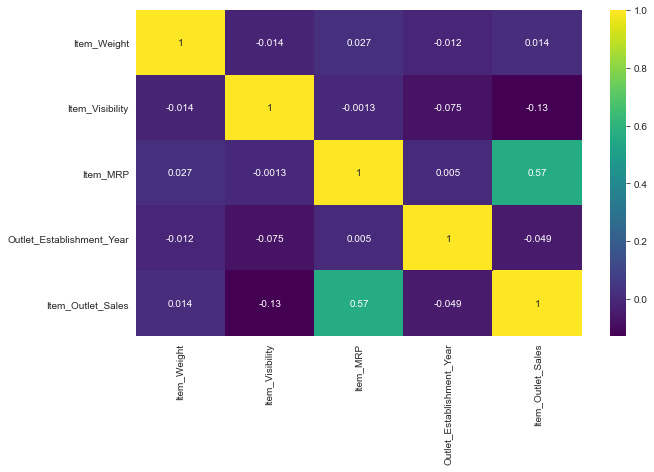

In [18]:
plt.figure(figsize=(10,6))
sns.heatmap(train.corr(),cmap='viridis',annot=True)
plt.show()

In [19]:
test.isna().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [20]:
for i in test.select_dtypes(object).columns[1:-1]:
    print('The unique values for feature '+  "\033[1m" + i + "\033[0m" + ' are: ',end='')
    print(*test[i].unique(),sep=', ')  
    print()

The unique values for feature Item_Fat_Content are: Low Fat, reg, Regular, LF, low fat

The unique values for feature Item_Type are: Snack Foods, Dairy, Others, Fruits and Vegetables, Baking Goods, Health and Hygiene, Breads, Hard Drinks, Seafood, Soft Drinks, Household, Frozen Foods, Meat, Canned, Starchy Foods, Breakfast

The unique values for feature Outlet_Identifier are: OUT049, OUT017, OUT010, OUT027, OUT046, OUT018, OUT045, OUT019, OUT013, OUT035

The unique values for feature Outlet_Size are: Medium, nan, Small, High

The unique values for feature Outlet_Location_Type are: Tier 1, Tier 2, Tier 3



In [21]:
test['Item_Fat_Content'] = test['Item_Fat_Content'].apply(lambda x: 'Low Fat' if 'f' in x.lower() else 'Regular') 

In [22]:
# combining the testing and training data
test['Source'] = 'test'
train['Source'] = 'train'
data = pd.concat([train,test],ignore_index=True)
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Source
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,train
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train


In [23]:
data.tail()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Source
14199,FDB58,10.5,Regular,0.013496,Snack Foods,141.3154,OUT046,1997,Small,Tier 1,Supermarket Type1,NaN,test
14200,FDD47,7.6,Regular,0.142991,Starchy Foods,169.1448,OUT018,2009,Medium,Tier 3,Supermarket Type2,NaN,test
14201,NCO17,10.0,Low Fat,0.073529,Health and Hygiene,118.7440,OUT045,2002,NaN,Tier 2,Supermarket Type1,NaN,test
14202,FDJ26,15.3,Regular,0.000000,Canned,214.6218,OUT017,2007,NaN,Tier 2,Supermarket Type1,NaN,test
14203,FDU37,9.5,Regular,0.104720,Canned,79.7960,OUT045,2002,NaN,Tier 2,Supermarket Type1,NaN,test


In [24]:
data.shape

(14204, 13)

# Feature Engineering

**Filling missing values**

In [25]:
data.drop(columns='Item_Outlet_Sales').isna().sum()

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Source                          0
dtype: int64

***Item_Weight***

In [26]:
data['Item_Weight'].fillna(data['Item_Weight'].mean(), inplace = True)

***Outlet_Size***

In [27]:
data['Outlet_Size'].fillna(data['Outlet_Size'].mode()[0], inplace = True)

In [28]:
data.drop(columns='Item_Outlet_Sales').isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Source                       0
dtype: int64

***Item Visibilty***

The Item_Visibility had a minimum value of 0, but all items need to some visibility which is not captured by 0.

In [29]:
data[data['Item_Visibility']==0]['Item_Visibility'].count()

879

In [30]:
data['Item_Visibility'].replace(0,data['Item_Visibility'].median(),inplace=True)

***Establishment Year***
We know in which year the outlet was established and we are going to calculate years that the outlet has been established.

In [31]:
data['Outlet_Establishment_Year'].value_counts()

1985    2439
1987    1553
1999    1550
1997    1550
2004    1550
2002    1548
2009    1546
2007    1543
1998     925
Name: Outlet_Establishment_Year, dtype: int64

In [32]:
data['Outlet_Years'] = 2010 - data['Outlet_Establishment_Year']
data.drop(columns = 'Outlet_Establishment_Year',inplace = True)

In [33]:
data['Outlet_Years'].describe()

count    14204.000000
mean        12.169319
std          8.371664
min          1.000000
25%          6.000000
50%         11.000000
75%         23.000000
max         25.000000
Name: Outlet_Years, dtype: float64

***Item_Identifier*** 

In [34]:
print(*data['Item_Identifier'].unique()[:10],sep=', ')

FDA15, DRC01, FDN15, FDX07, NCD19, FDP36, FDO10, FDP10, FDH17, FDU28


Three kinds of items **'FD':'Food'**,**'DR':'Drinks'** and **'NC':'Non-Consumable'**

In [35]:
data['Item_Id']=data['Item_Identifier'].apply(lambda x:'Food'if x[0:2]=='FD' else 'Drinks' if x[0:2]=='DR' else 'Non-Consumable')

In [36]:
data['Item_Id'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Id, dtype: int64

***If an item is not edible then we need to recategorize fat content of that item***

In [37]:
data.loc[data['Item_Id']=='Non-Consumable','Item_Fat_Content'] = 'Non-Edible'

In [38]:
data['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

**Based on item visibility we can associate importance given to a product in a store by dividing it by mean of visibility across all stores.**
**This is based on the assumption that important products are more visible in a store**

In [39]:
importance = data[['Item_Identifier','Item_Visibility']].groupby(by='Item_Identifier').mean()
importance

,Item_Visibility
Item_Identifier,
DRA12,0.046942
DRA24,0.045646
DRA59,0.138786
DRB01,0.086489
DRB13,0.012801
...,...
NCZ30,0.032704
NCZ41,0.063148
NCZ42,0.016417


In [40]:
data['Item_Importance'] = data.apply(lambda x: x['Item_Visibility']/(importance[importance.index==x['Item_Identifier']]['Item_Visibility'][0]),axis=1)

In [41]:
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Source,Outlet_Years,Item_Id,Item_Importance
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380,train,11,Food,0.931078
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228,train,1,Drinks,1.118538
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700,train,11,Food,0.972434
3,FDX07,19.20,Regular,0.054021,Fruits and Vegetables,182.0950,OUT010,Medium,Tier 3,Grocery Store,732.3800,train,12,Food,3.134317
4,NCD19,8.93,Non-Edible,0.054021,Household,53.8614,OUT013,High,Tier 3,Supermarket Type1,994.7052,train,23,Non-Consumable,3.134317


In [42]:
data.drop(columns = 'Item_Identifier', inplace= True)

In [43]:
data.shape

(14204, 14)

**Creating dummy variables for categorical data**

In [44]:
data.drop(columns = ['Source','Item_Type']).select_dtypes(object).columns

Index(['Item_Fat_Content', 'Outlet_Identifier', 'Outlet_Size',
       'Outlet_Location_Type', 'Outlet_Type', 'Item_Id'],
      dtype='object')

In [45]:
data = pd.get_dummies(data, columns = data.drop(columns='Source').select_dtypes(object).columns,drop_first=True)
data.shape

(14204, 42)

In [46]:
data.drop(columns = 'Item_Visibility', inplace=True)

# Model Building

In [47]:
train = data.loc[data['Source']=='train']
train.drop(columns = 'Source', inplace = True)
train.shape

(8523, 40)

In [48]:
test = data.loc[data['Source']=='test']
test.drop(columns = ['Source','Item_Outlet_Sales'], inplace = True)
test.shape

(5681, 39)

In [49]:
X = train.drop(columns = ['Item_Outlet_Sales'])
y = train['Item_Outlet_Sales']
X_test = test

In [50]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.15, random_state = 1)

**Linear Regression**

In [51]:
lr = LinearRegression(normalize=True)
lr.fit(X_train,y_train)

LinearRegression(normalize=True)

In [52]:
# Mean Absolute Error on training data
print('Mean Square Root Error on training data: {:.2f}'.format(np.sqrt(mean_squared_error(y_train,lr.predict(X_train)))))

Mean Square Root Error on training data: 1129.47


In [53]:
# Mean Absolute Error on validation data
print('Mean Square Root Error on validation data: {:.2f}'.format(np.sqrt(mean_squared_error(y_val,lr.predict(X_val)))))

Mean Square Root Error on validation data: 1116.01


**Lasso**

In [54]:
lasso = Lasso(normalize=True)
params = {'alpha':np.arange(0.1,1.1,0.1)}
grid = GridSearchCV(lasso,param_grid=params,cv=5)

In [55]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=Lasso(normalize=True),
             param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])})

In [56]:
grid.best_score_

0.5603520942184333

In [57]:
lasso = grid.best_estimator_
lasso.fit(X_train,y_train)

Lasso(alpha=0.1, normalize=True)

In [58]:
# Mean Absolute Error on training data
print('Mean Square Root Error on training data: {:.2f}'.format(np.sqrt(mean_squared_error(y_train,lasso.predict(X_train)))))

Mean Square Root Error on training data: 1130.34


In [59]:
# Mean Absolute Error on validation data
print('Mean Square Root Error on validation data: {:.2f}'.format(np.sqrt(mean_squared_error(y_val,lasso.predict(X_val)))))

Mean Square Root Error on validation data: 1114.37


In [60]:
features_importanance_lasso = X_train.columns[lasso.coef_==0]

In [61]:
len(features_importanance_lasso)

23

**DecisionTreeRegressor**

In [62]:
params = {   "min_samples_split": [13,15,17],
              "max_depth": [4, 5, 6, 8],
              "min_samples_leaf": [150, 130, 100, None],
              "max_leaf_nodes": [5, 20, 100, None],
          }
grid = GridSearchCV(DecisionTreeRegressor(), param_grid=params, cv = 5, verbose = 10, n_jobs=-1)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6, 8],
                         'max_leaf_nodes': [5, 20, 100, None],
                         'min_samples_leaf': [150, 130, 100, None],
                         'min_samples_split': [13, 15, 17]},
             verbose=10)

In [63]:
dtree = grid.best_estimator_
dtree.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=6, max_leaf_nodes=100, min_samples_leaf=100,
                      min_samples_split=13)

In [64]:
grid.best_params_

{'max_depth': 6,
 'max_leaf_nodes': 100,
 'min_samples_leaf': 100,
 'min_samples_split': 13}

In [65]:
# Mean Absolute Error on training data
print('Mean Square Root Error on training data: {:.2f}'.format(np.sqrt(mean_squared_error(y_train,dtree.predict(X_train)))))

Mean Square Root Error on training data: 1068.59


In [66]:
# Mean Absolute Error on validation data
print('Mean Square Root Error on validation data: {:.2f}'.format(np.sqrt(mean_squared_error(y_val,dtree.predict(X_val)))))

Mean Square Root Error on validation data: 1064.17


In [67]:
features_importanance = pd.DataFrame(dtree.feature_importances_,index=X_train.columns,columns=['Feature Importance'])
features_importanance_dtree = features_importanance[features_importanance==0].index

In [68]:
len(features_importanance_dtree)

39

In [69]:
not_important_features= list(set(features_importanance_dtree).intersection(set(features_importanance_lasso)))
not_important_features

['Item_Type_Soft Drinks',
 'Item_Type_Others',
 'Outlet_Size_Small',
 'Item_Type_Canned',
 'Item_Type_Hard Drinks',
 'Item_Type_Frozen Foods',
 'Outlet_Size_Medium',
 'Outlet_Years',
 'Item_Fat_Content_Non-Edible',
 'Item_Type_Breakfast',
 'Outlet_Location_Type_Tier 3',
 'Item_Type_Snack Foods',
 'Outlet_Identifier_OUT046',
 'Item_Type_Fruits and Vegetables',
 'Item_Type_Starchy Foods',
 'Outlet_Identifier_OUT013',
 'Outlet_Location_Type_Tier 2',
 'Item_Type_Breads',
 'Item_Weight',
 'Item_Type_Meat',
 'Item_Id_Non-Consumable',
 'Item_Type_Household',
 'Item_Type_Health and Hygiene']

In [70]:
len(not_important_features)

23

**RandomForestRegressor**

In [71]:
rfc = RandomForestRegressor()
rfc.fit(X_train,y_train)

RandomForestRegressor()

In [72]:
# Mean Absolute Error on training data
print('Mean Square Root Error on training data: {:.2f}'.format(np.sqrt(mean_squared_error(y_train,rfc.predict(X_train)))))

Mean Square Root Error on training data: 425.76


In [73]:
# Mean Absolute Error on validation data
print('Mean Square Root Error on validation data: {:.2f}'.format(np.sqrt(mean_squared_error(y_val,rfc.predict(X_val)))))

Mean Square Root Error on validation data: 1130.29


**XGBoost Regressor**

In [74]:
xgb = XGBRegressor()
xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [75]:
# Mean Absolute Error on training data
print('Mean Square Root Error on training data: {:.2f}'.format(np.sqrt(mean_squared_error(y_train,xgb.predict(X_train)))))

Mean Square Root Error on training data: 665.18


In [76]:
# Mean Absolute Error on validation data
print('Mean Square Root Error on validation data: {:.2f}'.format(np.sqrt(mean_squared_error(y_val,xgb.predict(X_val)))))

Mean Square Root Error on validation data: 1158.52


In [77]:
params = {
        'gamma': [0,0.01,0.05],
        'learning_rate': [0.047,0.05,0.053],
        'max_depth': [3,4,5,10],
        'n_estimators': [150,140,145,130],
    }

In [78]:
grid = GridSearchCV(xgb, param_grid=params,n_jobs=-1,cv=5)

In [79]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=100, n_jobs=12,
                                    num_parallel_tree=1, random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, subsample=1,
                                    tree_method='exact', validate_parameters=1,
                                    verbosity=None),
     

In [80]:
grid.best_score_

0.5945530428981499

In [81]:
grid.best_params_

{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 140}

In [82]:
xgb = grid.best_estimator_

In [83]:
xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=140, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [84]:
# Mean Absolute Error on training data
print('Mean Square Root Error on training data: {:.2f}'.format(np.sqrt(mean_squared_error(y_train,xgb.predict(X_train)))))

Mean Square Root Error on training data: 1053.89


In [85]:
# Mean Absolute Error on validation data
print('Mean Square Root Error on validation data: {:.2f}'.format(np.sqrt(mean_squared_error(y_val,xgb.predict(X_val)))))

Mean Square Root Error on validation data: 1062.54


In [86]:
predictions = xgb.predict(X_test)